# Tutorial II: Fully connected NNs

<p>
AICP, 2024<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected neural network to perform handwritten digit recognition using pytorch

## 1. Load necessary libraries



In [1]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader


## 2. Training loop

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, batches, and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

## 3. Bulding blocks of a neural network

Neural network consists of layers of neurons. Each neuron performs 2 operations.

1. Calculate the linear transformation of the input vector $\mathbf{x}_i$:

$z_i = \mathbf{w} \cdot \mathbf{x}_i + b = \sum_j {w_j x_{ij}} + b$

 where $\mathbf{w}$ is a weight vector and $b$ - a bias, and $j$ traverses each dimension of the input vector
2. Perform the nonlinear transformation of the result using the activation function $f$ $$y_i = f(z_i)$$

In a fully connected neural network, each layer is a set of N neurons, performing different transformations of the input $\mathbf{x}_i$ of the same layer, now producing an output **vector** $ \mathbf{y} _i = f(\mathbf{z}_i) = f(W\mathbf{x}_i + \mathbf{b})$ now with a bias vector $\mathbf{b}$ and a * *matrix** of weights $W$.

Since the output of each layer constitutes the input to the next layer, we can write for layer $l$: $$\mathbf{x}^l_i = f^{l-1}(\mathbf{W}^{ l-1} \mathbf{x}^{ l-1}_i + \mathbf{b}^{l-1})$$ where $\mathbf{x}_i^{l=0}$ is the vector d 'network input for data point $i$.

In the case of multi-class classification, in the last layer, we can use the *softmax* transformation as a non-linear transformation. The softmax for the $j$th element of $\mathbf{z}_i$ is $$y_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{K} e^{z_{ik}}}$$ where $K$ is the total number of classes.


For example. before softmax $$[1.0, 2.0, 3.0, \mathbf{4.0} ]$$ and after: $$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}]$$ (now the sum is equal to one)

We can also now compare the fundamental truth which could be $$[0,0,0,\mathbf{1}]$$ That is to say that class 4 is the good class and that the network predicted correctly.



The **optimization/loss function** in multiclass classification problems is multiclass cross-entropy:

$\mathcal{L}_i = - \sum_{k=1}^K y^*_{ik} \log(y_{ik})$

 where $y^*_{ik}$ is the $k$-th component of the unique true label vector $\mathbf{y}^*_i$, and $y_{ik}$ is the $k$-th component of the predicted probability vector $\mathbf{y}_i$.

$$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}] = [y_{i1}, y_{i2}, y_{i3}, y_{i4}]$$

## 4. Structure of a neural network

In [2]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_hiddens, n_output):
        super(MyModel, self).__init__()

        self.ls = []
        n_prev = n_input
        for i, n_out in enumerate(n_hiddens):
          l = nn.Linear(n_prev, n_out)  # for hidden layer we create a linear projection form n_prev features to n_out features
          n_prev = n_out
          self.add_module(f'lin_{i}_{n_out}', l)
          self.ls.append(l)

        self.lout = nn.Linear(n_prev, n_output)  # also we need the output layer

    def forward(self, x):
        h = x
        for li in self.ls:  # for each layer we apply the linear projection and the activation function (ReLU)
          h = li(h)
          h = torch.relu(h)

        logits = self.lout(h)
        # Apply softmax activation per row, to get the class pseudoprobabilities
        probs = F.softmax(logits, dim=1)

        # Prediction: argmax for classification
        pred = torch.argmax(probs, dim=1)  # find the element with highest value in each row

        return logits, probs, pred


## 5. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.

Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.

In [7]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


In [4]:
# Das Datatset hat 10 Klassen, deshalb Ausgabe = 9 (inklusive 0)
for el in trainset:
  x, y = el
  print(x.shape, y)
  break

torch.Size([784]) 9


In [5]:
for el in trainloader:
  x, y = el
  print(x.shape, y.shape)
  break

torch.Size([64, 784]) torch.Size([64])


 Let's take a look at some of the example images

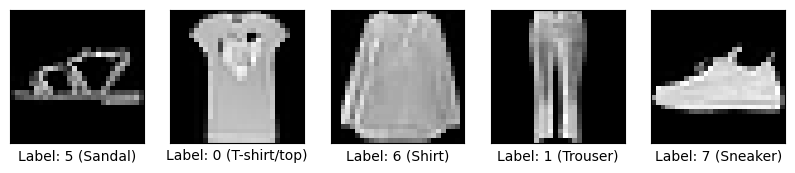

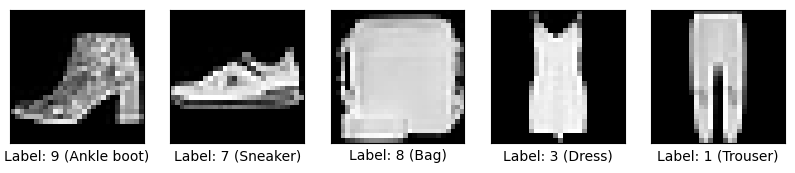

In [6]:
class_names = trainset.classes
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Reshape the flattened images back to 28x28 for display
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray') 
        lbl = labels[i].item()
        plt.xlabel(f'Label: {lbl} ({class_names[lbl]})')
    plt.show()

# Function to get random images and labels from a dataset
def get_random_images(loader, num_images=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    indices = list(range(len(images)))
    random_indices = random.sample(indices, num_images)
    random_images = images[random_indices]
    random_labels = labels[random_indices]
    return random_images, random_labels

# Get random images and labels from the training set
random_images, random_labels = get_random_images(trainloader, num_images=5)
# Show images
show_images(random_images, random_labels, num_images=5)

# and for the test set:
random_images, random_labels = get_random_images(testloader, num_images=5)
show_images(random_images, random_labels, num_images=5)



Check out the dimensions of the data

In [46]:
# Inspect the dimensions of the sample elements
print("Shape of the images:", random_images.shape)
print("Shape of the labels:", random_labels.shape)
print(random_labels)

Shape of the images: torch.Size([5, 784])
Shape of the labels: torch.Size([5])
tensor([6, 8, 1, 9, 0])


## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [8]:
n_hidden = []  # [10]
model = MyModel(n_input=784, n_hiddens=n_hidden, n_output=10)  # 784 input features for 28x28 images, 10 output classes

In [9]:
def get_npars(model):
    """
    Returns the total number of parameters in the given PyTorch model.
    For each parmaeter in the model, the function multiplies the elements of the shape
    of the parameter tensor to get the total number of parameters.
    
    Args:
        model (torch.nn.Module): The PyTorch model to get the number of parameters for.
    
    Returns:
        int: The total number of parameters in the model.
    """
    n = np.sum([np.prod(list(p.shape)) for p in model.parameters()])
    return int(n)

In [11]:
# Gives back the number of parameters
get_npars(model)

7850

In [12]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Defining a training function:

In [13]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # reset gradients
        output, _, _ = model(images) # Unterstriche _ bedeuten, dass wir diese beiden Outputs ignorieren
        loss = criterion(output, labels)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()
    return running_loss / len(trainloader)

Defining a testing function:

In [14]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            output, prob, pred = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
            correct = torch.sum(pred == labels)
            n_correct =+ correct
    return running_loss / len(testloader)  #, n_correct/len(testloader)/testloader.batch_size

In [15]:
testloader.batch_size

64

Training the model

In [16]:
num_epochs = 10
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss = test(model, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.5577, Test Loss: 0.4918
Epoch 2/10, Train Loss: 0.4525, Test Loss: 0.4747
Epoch 3/10, Train Loss: 0.4347, Test Loss: 0.4771
Epoch 4/10, Train Loss: 0.4246, Test Loss: 0.4597
Epoch 5/10, Train Loss: 0.4173, Test Loss: 0.4546
Epoch 6/10, Train Loss: 0.4140, Test Loss: 0.4712
Epoch 7/10, Train Loss: 0.4075, Test Loss: 0.4554
Epoch 8/10, Train Loss: 0.4047, Test Loss: 0.4508
Epoch 9/10, Train Loss: 0.4025, Test Loss: 0.4507
Epoch 10/10, Train Loss: 0.4005, Test Loss: 0.4500


Visualize the loss curves

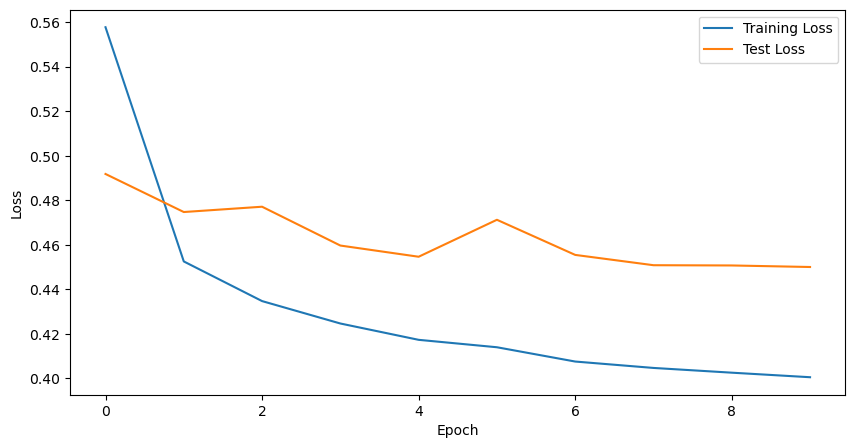

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [18]:
for p in model.parameters():
  print(np.prod(list(p.shape)))

7840
10


In [19]:
get_npars(model)

7850

Evaluate network performance using a basic accuracy metric:

${Acc}= \frac{1}{N}\sum_{i=1}^N \mathbb{I}(y_i = y^*_i)$

where $\mathbb{I}()$ is the indicator function.


Also investigate what an incorrect prediction looks like...

In [20]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8396434294871795


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 12


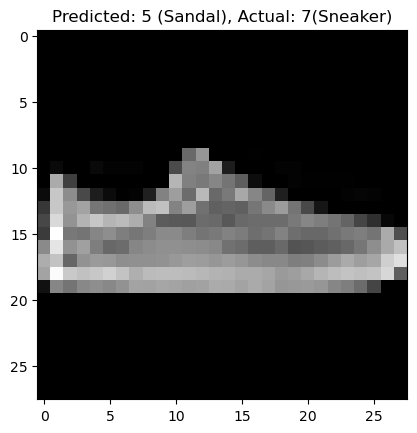

First correct digit is at index: 0


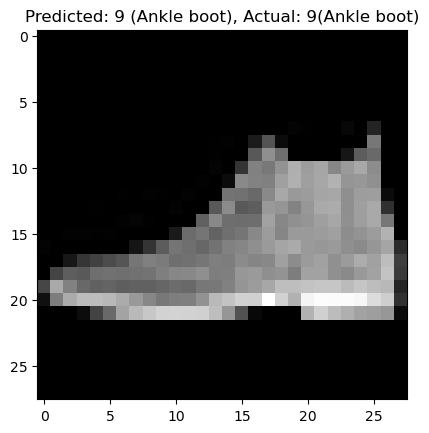

In [21]:

# Find the index of the first incorrect and correct prediction
wrong_idx = next((i for i, correct in enumerate(correct) if not correct), None)
correct_idx = next((i for i, correct in enumerate(correct) if correct), None)

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect sample (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    pred = predictions[wrong_idx]
    lbl  = labels[wrong_idx]
    display_image(images_list[wrong_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No incorrect predictions found")

# Display the first correct sample (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    pred = predictions[correct_idx]
    lbl  = labels[correct_idx]
    display_image(images_list[correct_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

The model's layers are stored in model.ls and model.lout - for the output layer.
In out case this is the only layer.

The learned model parameters W1 are a matrix of weights that show importance of each input pixel (784) for each of the 10 outputs.

torch.Size([10, 784]) torch.Size([10])


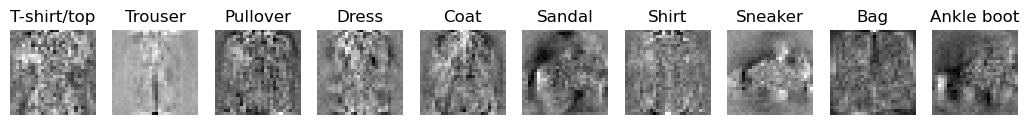

In [22]:
layer = model.lout
n_features = layer.out_features
w1, b1 = layer.weight.data, layer.bias.data
print(w1.shape, b1.shape)

w1_reshaped = w1.view(n_features, 28, 28)  # Adjust the view dimensions as per your layer's configuration

# Plotting the weights
_, axs = plt.subplots(1, n_features, figsize=(13, 5))

for i in range(10):
    axs[i].imshow(w1_reshaped[i].numpy(), cmap='gray', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].set_title(f'{trainset.classes[i]}')
plt.show()

Here we classify images into 10 classes. But think of it: does the network know, or need to know that those were images? For the network each image is just a 784 values. And it finds that there is a patten.

Same way one can feed any other bunch of numbers, and the network will try it's best to fugure out a relation pattern between those.






In [23]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, probs, pred = model(images)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy



In [24]:
predictions, labels, images_list = get_predictions(model, testloader)  # TEST

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8396434294871795


To save the trained model we save its state diictionary.
Saving the state of the optimizer is optional, but allows to resume training from the same point.

In [25]:
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(save_dict, f'trained_model.pth')

# to load: 

# load_dict = torch.load('trained_model.pth')
# model.load_state_dict(load_dict['model_state_dict'])
# optimizer.load_state_dict(load_dict['optimizer_state_dict'])



## 7. Exercise 1 (40 min)

Build a network with two layers, first with `tf.nn.relu` ReLU activation and 1500 neurons and second one with 10 and softmax activation. Start with `learning_rate` of 0.001 and find optimal value.

## 8. Gradients visualization

We will display several images, and corresponding gradients of maximal output activation, as well as all activations. This might help better understand how our network processes the imput data.

In [55]:
model.eval()
grads_all_classes = []


# The code uses torch.autograd.grad to compute the gradients of the model's predictions with respect to the input image.
# This essentially answers the question, "How does changing each pixel in the input image affect the model's confidence in its prediction for each class (digit)?"

# For each digit class (0 to 9), the code computes a separate gradient map.
# It does so by setting grad_outputs to a tensor that is all zeros except for a one at the current class's position.
# This way, the computed gradient reflects how much each pixel in the input image contributes to the model's prediction for that specific class.

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Choose an index and select a single image and label
idx = 10
inp_v = images[idx:idx+1]  # Selecting the image
img = inp_v.squeeze()  # The original 2D image for display

# Enable gradients for input
inp_v.requires_grad = True

# Forward pass and compute gradients
model.eval()
with torch.set_grad_enabled(True):
    preds = model(inp_v)[0]  # Assuming the model returns a tuple (output, argmax)
    for i in range(preds.size(1)):  # Iterate over each class
        grad_outputs = torch.zeros_like(preds)
        grad_outputs[0, i] = 1
        grads = torch.autograd.grad(outputs=preds, inputs=inp_v, grad_outputs=grad_outputs, create_graph=True)[0]
        grads_all_classes.append(grads)

# Stack all gradients and reshape to desired format
grads_stacked = torch.stack(grads_all_classes).view(preds.size(1), 28, 28).detach().numpy()



Each of the following subplots shows the gradient map for a particular class. These maps can be interpreted as heatmaps indicating which regions of the input image are most critical for the model's prediction of that particular digit.
Brighter areas in a gradient map indicate pixels that, if changed, would have a larger impact on the model's prediction for that class. This can give insights into what features the model is focusing on for each class.


https://medium.com/geekculture/how-visualizations-help-make-sense-of-deep-learning-a408ab00688f


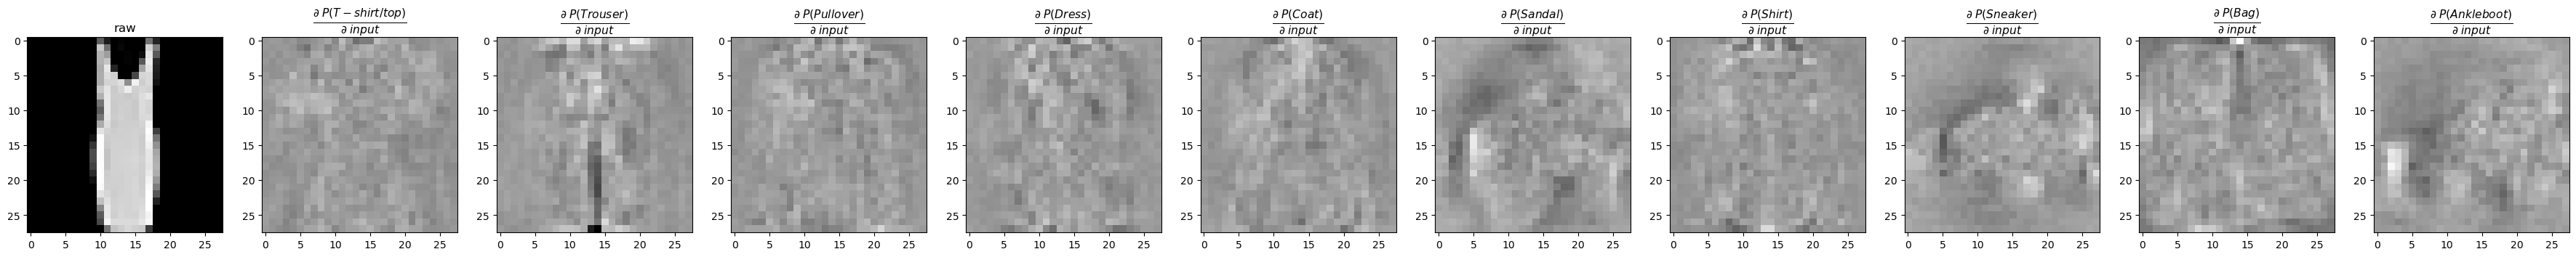

In [56]:
# Each of the following subplots shows the gradient map for a particular class.
# These maps can be interpreted as heatmaps indicating which regions of the input image are most critical for the model's prediction of that particular digit.
# Brighter areas in a gradient map indicate pixels that, if changed, would have a larger impact on the model's prediction for that class.
# This can give insights into what features the model is focusing on for each class.

# Reshape the flattened image back to 2D for display
img_2d = img.view(28, 28).numpy()

# Plotting
fig, axs = plt.subplots(1, 11, figsize=(4.1 * 11, 4))
axs[0].imshow(img_2d, cmap='gray')  # Display the reshaped original image
axs[0].set_title('raw')
vmin, vmax = grads_stacked.min(), grads_stacked.max()


for i, g in enumerate(grads_stacked):
    axs[i + 1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
    axs[i + 1].set_title(r'$\frac{\partial\;P(%s)}{\partial\;input}$' % class_names[i], fontdict={'size': 16})

plt.show()

## 9. Exercise 2
### Group 1
Build the network with 3 or more layers. Try to get test accuracy >93%.
Better to copy and modify the previous code so that you can compare against the code/results above.


### Group 2

You can repeat the same for a regression problem: here you will have just 1 output in the last layer, with no activation - to predict continuous unboud range. You can use the `mse` or `mae` loss. Compare results with a baseline linear / random forest model.

How many parameters does your model have as compared to number of samples?

In [ ]:


# example solution code for Group 2:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load Boston Housing dataset
cali = fetch_california_housing()
X, y = cali.data, cali.target

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Define a batch size
batch_size = 64

# Create DataLoaders for training and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



class MyRegressor(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyRegressor, self).__init__()
        # Layer 1: 10 inputs -> 4, with sigmoid activation
        self.l1 = nn.Linear(n_input, n_hidden)

        # Layer 2: 4 inputs -> n_output, with softmax activation
        self.l2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # Apply first layer and sigmoid activation
        x = torch.sigmoid(self.l1(x))
        return self.l2(x), self.l2(x)  # ugly workaround to make it compatible with earlier functions



n_input = x_train.shape[1]  # Number of features in the Boston Housing dataset
n_hidden = 4  # Example number of hidden units
n_output = 1  # Regression output

model = MyRegressor(n_input=n_input, n_hidden=n_hidden, n_output=n_output)

criterion = nn.MSELoss()  # For regression, Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss = test(model, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [ ]:
rf = RandomForestRegressor()

# Train the random forest model
rf.fit(x_train, y_train[:,0])

# Predict on the test set
rf_predictions = rf.predict(x_test)

# Calculate the test loss (MSE)
rf_test_loss = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest Test Loss: {rf_test_loss:.4f}')